In [2]:
# Import modules and set constants
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder

num_timesteps = 14

In [3]:
air_reserve = pd.read_csv('air_reserve.csv')
hpg_reserve = pd.read_csv('hpg_reserve.csv')
air_visit_data = pd.read_csv('air_visit_data.csv')
air_store_info = pd.read_csv('air_store_info.csv')
hpg_store_info = pd.read_csv('hpg_store_info.csv')
store_id_relation = pd.read_csv('store_id_relation.csv')
date_info = pd.read_csv('date_info.csv')

In [4]:
# Process reservation data
merged_air_reserve = pd.merge(air_reserve, store_id_relation, on='air_store_id', how='left')

merged = pd.merge(merged_air_reserve, hpg_reserve, how='left')

merged['visit_date'] = pd.to_datetime(merged['visit_datetime']).dt.date

reservation_data = merged.groupby(['air_store_id', 'visit_date'])['reserve_visitors'].sum().reset_index()
reservation_data.head()

,air_store_id,visit_date,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,2
1,air_00a91d42b08b08d9,2016-12-05,9
2,air_00a91d42b08b08d9,2016-12-14,18
3,air_00a91d42b08b08d9,2016-12-17,2
4,air_00a91d42b08b08d9,2016-12-20,4


In [5]:
# Process visit data
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date']).dt.date
air_visit_data.dropna(subset=['visitors'], inplace=True)
visit_data = air_visit_data
visit_data.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [6]:
# Process store data
store_data = pd.merge(air_store_info, store_id_relation, on='air_store_id', how='left')
store_data = pd.merge(store_data, hpg_store_info.drop(['latitude', 'longitude'], axis=1), on='hpg_store_id', how='left')
store_data['hpg_genre_name'].fillna('None', inplace=True)
store_data['hpg_area_name'].fillna('None', inplace=True)
store_data['use_hpg'] = 0
store_data.loc[store_data['hpg_store_id'].notnull(), 'use_hpg'] = 1
store_data.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,use_hpg
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,None,None,0
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,hpg_9b38b9e13da6da27,None,None,1
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,None,None,0
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,None,None,0
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,None,None,0


In [7]:
## Process date data
date_info.drop('day_of_week', axis=1, inplace=True)
date_info.rename(columns={ 'calendar_date': 'visit_date' }, inplace=True)
date_info['visit_date'] = pd.to_datetime(date_info['visit_date']).dt.date
date_info.head()

,visit_date,holiday_flg
0,2016-01-01,1
1,2016-01-02,1
2,2016-01-03,1
3,2016-01-04,0
4,2016-01-05,0


In [13]:
# Merge datasets
merged = pd.merge(visit_data, reservation_data, on=['air_store_id', 'visit_date'], how='left')
merged['reserve_visitors'].fillna(0, inplace=True)
merged = pd.merge(merged, store_data, on='air_store_id', how='left')
merged = pd.merge(merged, date_info, on='visit_date', how='left')
merged.head()

,air_store_id,visit_date,visitors,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,use_hpg,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,0.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,None,None,0,0
1,air_ba937bf13d40fb24,2016-01-14,32,0.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,None,None,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,0.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,None,None,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,0.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,None,None,0,0
4,air_ba937bf13d40fb24,2016-01-18,6,0.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,None,None,0,0


In [14]:
# Preprocess
le = LabelEncoder()
ohe = OneHotEncoder(sparse_output=False)

merged['visit_year'] = pd.to_datetime(merged['visit_date']).dt.year
merged['visit_month'] = pd.to_datetime(merged['visit_date']).dt.month
merged['visit_day'] = pd.to_datetime(merged['visit_date']).dt.day
merged['visit_weekday'] = pd.to_datetime(merged['visit_date']).dt.weekday

month_mean_visitors = merged.groupby(['air_store_id', 'visit_month'])['visitors'].mean().reset_index().rename(columns={ 'visitors': 'month_mean_visitors' })
merged = pd.merge(merged, month_mean_visitors, on=['air_store_id', 'visit_month'], how='left')

month_median_visitors = merged.groupby(['air_store_id', 'visit_month'])['visitors'].median().reset_index().rename(columns={ 'visitors': 'month_median_visitors' })
merged = pd.merge(merged, month_median_visitors, on=['air_store_id', 'visit_month'], how='left')

month_min_visitors = merged.groupby(['air_store_id', 'visit_month'])['visitors'].min().reset_index().rename(columns={ 'visitors': 'month_min_visitors' })
merged = pd.merge(merged, month_min_visitors, on=['air_store_id', 'visit_month'], how='left')

month_max_visitors = merged.groupby(['air_store_id', 'visit_month'])['visitors'].max().reset_index().rename(columns={ 'visitors': 'month_max_visitors' })
merged = pd.merge(merged, month_max_visitors, on=['air_store_id', 'visit_month'], how='left')

weekday_mean_visitors = merged.groupby(['air_store_id', 'visit_weekday'])['visitors'].mean().reset_index().rename(columns={ 'visitors': 'weekday_mean_visitors' })
merged = pd.merge(merged, weekday_mean_visitors, on=['air_store_id', 'visit_weekday'], how='left')

weekday_median_visitors = merged.groupby(['air_store_id', 'visit_weekday'])['visitors'].median().reset_index().rename(columns={ 'visitors': 'weekday_median_visitors' })
merged = pd.merge(merged, weekday_median_visitors, on=['air_store_id', 'visit_weekday'], how='left')

weekday_min_visitors = merged.groupby(['air_store_id', 'visit_weekday'])['visitors'].min().reset_index().rename(columns={ 'visitors': 'weekday_min_visitors' })
merged = pd.merge(merged, weekday_min_visitors, on=['air_store_id', 'visit_weekday'], how='left')

weekday_max_visitors = merged.groupby(['air_store_id', 'visit_weekday'])['visitors'].max().reset_index().rename(columns={ 'visitors': 'weekday_max_visitors' })
merged = pd.merge(merged, weekday_max_visitors, on=['air_store_id', 'visit_weekday'], how='left')

merged['air_genre_name'] = le.fit_transform(merged['air_genre_name'])
merged['air_area_name'] = le.fit_transform(merged['air_area_name'])
merged['hpg_genre_name'] = le.fit_transform(merged['hpg_genre_name'])
merged['hpg_area_name'] = le.fit_transform(merged['hpg_area_name'])

order = [
    'use_hpg',
    'visit_year',
    'visit_month',
    'visit_day',
    'visit_weekday',
    'month_mean_visitors',
    'month_median_visitors',
    'month_min_visitors',
    'month_max_visitors',
    'weekday_mean_visitors',
    'weekday_median_visitors',
    'weekday_min_visitors',
    'weekday_max_visitors',
    'holiday_flg',
    'air_genre_name',
    'air_area_name',
    'hpg_genre_name',
    'hpg_area_name',
    'latitude',
    'longitude',
    'reserve_visitors',
    'visitors',
]
merged = merged.loc[:, order].astype(float)

visit_weekday_encoded = ohe.fit_transform(merged['visit_weekday'].values.reshape(-1, 1))
visit_weekday_df = pd.DataFrame(visit_weekday_encoded, columns=ohe.get_feature_names_out(['visit_weekday']))
visit_weekday_index = merged.columns.get_loc('visit_weekday')
preprocessed_data = pd.concat([merged.iloc[:, :visit_weekday_index + 1], visit_weekday_df, merged.iloc[:, visit_weekday_index + 1:]], axis=1)
preprocessed_data.drop('visit_weekday', axis=1, inplace=True)

train_data = preprocessed_data[preprocessed_data['visit_year'] == 2016].copy()
test_data = preprocessed_data[preprocessed_data['visit_year'] == 2017].copy()
train_data.drop('visit_year', axis=1, inplace=True)
test_data.drop('visit_year', axis=1, inplace=True)

X_train = train_data.drop('visitors', axis=1).values
Y_train = train_data['visitors'].values
X_test = test_data.drop('visitors', axis=1).values
Y_test = test_data['visitors'].values

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

num_features = X_train.shape[1]
num_samples = len(X_train) - num_timesteps + 1

X = np.zeros((num_samples, num_timesteps, num_features))
Y = np.zeros((num_samples, 1))
for i in range(num_samples):
    X[i] = X_train[i : i + num_timesteps].reshape((-1, num_features))
    Y[i] = Y_train[i + num_timesteps - 1]
X_train, Y_train = X, Y

num_samples = len(X_test) - num_timesteps + 1
X = np.zeros((num_samples, num_timesteps, num_features))
Y = np.zeros((num_samples, 1))
for i in range(num_samples):
    X[i] = X_test[i : i + num_timesteps].reshape((-1, num_features))
    Y[i] = Y_test[i + num_timesteps - 1]
X_test, Y_test = X, Y

print('Shapes:')
print('  X_train: ', X_train.shape)
print('  Y_train: ', Y_train.shape)
print('  X_test: ', X_test.shape)
print('  Y_test: ', Y_test.shape)

Shapes:
  X_train:  (174522, 14, 26)
  Y_train:  (174522, 1)
  X_test:  (77560, 14, 26)
  Y_test:  (77560, 1)


In [17]:
# Define requirements for model
def rmsletf(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.math.squared_difference(tf.math.log1p(y_pred), tf.math.log1p(y_true))))

input_shape = (X_train.shape[1], X_train.shape[2])

In [24]:
# Build and train model
model = models.Sequential()
model.add(layers.LSTM(26, input_shape=input_shape))
model.add(layers.Dense(13, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.compile(optimizer='sgd', loss=rmsletf)
model.summary()

model.fit(X_train, Y_train, epochs=20, batch_size=64)

test_loss = model.evaluate(X_test, Y_test)
print('test_loss: ', test_loss)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 26)                5512      
                                                                 
 dense_14 (Dense)            (None, 13)                351       
                                                                 
 dense_15 (Dense)            (None, 1)                 14        
                                                                 
Total params: 5,877
Trainable params: 5,877
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2727/2727 [==============================] - 8s 3ms/step - loss: 0.8929
Epoch 2/20
2727/2727 [==============================] - 7s 3ms/step - loss: 0.7437
Epoch 3/20
2727/2727 [==============================] - 7s 3ms/step - loss: 0.6098
Epoch 4/20
2727/2727 [==============================] - 7s 3ms/step

In [25]:
# Optimized with RMSprop
model_1 = models.Sequential()
model_1.add(layers.LSTM(26, input_shape=input_shape))
model_1.add(layers.Dense(13, activation='relu'))
model_1.add(layers.Dense(1, activation='relu'))
model_1.compile(optimizer='rmsprop', loss=rmsletf)
model_1.summary()

model_1.fit(X_train, Y_train, epochs=20, batch_size=64)

test_loss = model_1.evaluate(X_test, Y_test)
print('test_loss: ', test_loss)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 26)                5512      
                                                                 
 dense_16 (Dense)            (None, 13)                351       
                                                                 
 dense_17 (Dense)            (None, 1)                 14        
                                                                 
Total params: 5,877
Trainable params: 5,877
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2727/2727 [==============================] - 9s 3ms/step - loss: 0.6165
Epoch 2/20
2727/2727 [==============================] - 7s 3ms/step - loss: 0.5004
Epoch 3/20
2727/2727 [==============================] - 8s 3ms/step - loss: 0.4919
Epoch 4/20
2727/2727 [==============================] - 8s 3ms/ste

In [26]:
# Optimized with Adam
model_2 = models.Sequential()
model_2.add(layers.LSTM(26, input_shape=input_shape))
model_2.add(layers.Dense(13, activation='relu'))
model_2.add(layers.Dense(1, activation='relu'))
model_2.compile(optimizer='adam', loss=rmsletf)
model_2.summary()

model_2.fit(X_train, Y_train, epochs=20, batch_size=64)

test_loss = model_2.evaluate(X_test, Y_test)
print('test_loss: ', test_loss)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 26)                5512      
                                                                 
 dense_18 (Dense)            (None, 13)                351       
                                                                 
 dense_19 (Dense)            (None, 1)                 14        
                                                                 
Total params: 5,877
Trainable params: 5,877
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2727/2727 [==============================] - 9s 3ms/step - loss: 0.6144
Epoch 2/20
2727/2727 [==============================] - 7s 3ms/step - loss: 0.5003
Epoch 3/20
2727/2727 [==============================] - 7s 3ms/step - loss: 0.4917
Epoch 4/20
2727/2727 [==============================] - 7s 3ms/ste

In [27]:
# Optimized with Adamax
model_3 = models.Sequential()
model_3.add(layers.LSTM(26, input_shape=input_shape))
model_3.add(layers.Dense(13, activation='relu'))
model_3.add(layers.Dense(1, activation='relu'))
model_3.compile(optimizer='adamax', loss=rmsletf)
model_3.summary()

model_3.fit(X_train, Y_train, epochs=20, batch_size=64)

test_loss = model_3.evaluate(X_test, Y_test)
print('test_loss: ', test_loss)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 26)                5512      
                                                                 
 dense_20 (Dense)            (None, 13)                351       
                                                                 
 dense_21 (Dense)            (None, 1)                 14        
                                                                 
Total params: 5,877
Trainable params: 5,877
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2727/2727 [==============================] - 9s 3ms/step - loss: 0.7363
Epoch 2/20
2727/2727 [==============================] - 7s 3ms/step - loss: 0.5542
Epoch 3/20
2727/2727 [==============================] - 7s 3ms/step - loss: 0.5131
Epoch 4/20
2727/2727 [==============================] - 7s 3ms/ste

In [42]:
# Prediction
Y_pred = model.predict(X_test)
if len(Y_pred.shape) == 3: Y_pred = np.squeeze(Y_pred, 2)
Y_pred = np.round(np.mean(Y_pred, axis=1)).reshape(Y_test.shape)
predict_loss = np.sqrt(np.mean(np.square(np.log1p(Y_pred) - np.log1p(Y_test))))

print('Y_test: ', Y_test.shape)
print(Y_test)
print('Y_pred: ', Y_pred.shape)
print(Y_pred)
print('predict_loss: ', predict_loss)

2425/2425 [==============================] - 1s 336us/step
Y_test:  (77573,)
[11. 21. 16. ...  7.  8.  5.]
Y_pred:  (77573,)
[17. 23. 23. ...  5.  6.  6.]
predict_loss:  0.4868819810889711


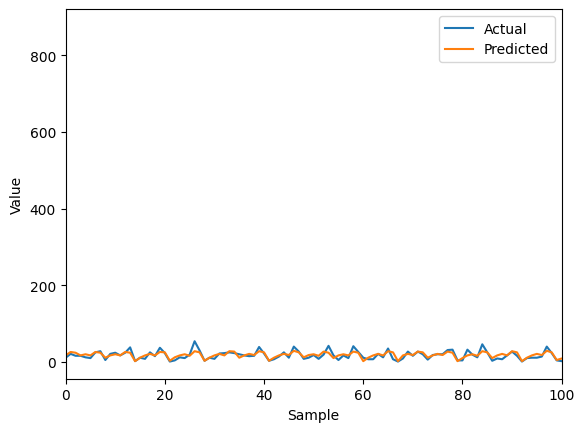

In [40]:
# Show plot
plt.plot(Y_test, label='Actual')
plt.plot(Y_pred, label='Predicted')

plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.xlim(0, 100)
plt.show()